# Simple Quark / Gluon discrimination example 

This is a simple example which uses jet shapes and a naive Bayes method (see e.g. [here](http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb))  to distinguish quark and gluon jets.

The name of this notebook respects the naming convention needed for the submission of the results (see the [README](https://gitlab.cern.ch/IML-WG/IMLWorkshop2017-Challenge/blob/master/README.md))

The classification is based on 4 jet shapes, which are computed in the [flat_helper.py](https://gitlab.cern.ch/IML-WG/IMLWorkshop2017-Challenge/blob/master/Examples/flat_helper.py) script. Have a look at this script for an example on how to iterate over the input trees. Two functions are provided:
* ```GetJetShapes```: The iteration happens in python, so this is relativelay slow
* ```GetJetShapesFast```: The iteration happens in a C macro ([CreateJetShapes.C](https://gitlab.cern.ch/IML-WG/IMLWorkshop2017-Challenge/blob/master/Examples/CreateJetShapes.C)) , and the shapes are written to a temporary root file. This is faster.

There is a slight difference in the interface of the 2 methods (GetJetShapes needs a pattern, GetJetShapesFast a folder).

To use this notebook, simply execute all cells one after the other.
The last cell also saves the AUC value to the text file needed for the submission of the results.


In [1]:
# basic imports
import ROOT
import flat_helper
import sys

Welcome to JupyROOT 6.08/06


In [2]:
%%bash
# This only needs to be executed the first time, comment it out if you used it already once.
# it installs an additional keras package and the extensions for the progress bar
# YOU NEED TO EXECUTE THIS ONLY THE FIRST TIME YOU RUN ON A SPECIFIC SWAN MACHINE (e.g. swan00x) and 
# YOU HAVE TO REFRESH THE PAGE FOR THE PROGRESSBARS TO SHOW
#pip install --user seaborn
jupyter nbextension enable --py widgetsnbextension 

Unrecognized JSON config file version, assuming version 1
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# Load jet shapes. 
# The second argument indicates the number of jets to process (use -1 to process all available jets).
# The GetJetShapes[Fast] functions return a pandas data frame, and saves it to a  file for reuse. 
# If the file exist, the trees are not reprocessed. To force reprocessing (e.g. you want to include 
# more statistics) use the recompute=True argument.
# The calculation of jet shapes in the GetJetShapes function is somewhat slow, as the loops for the 
# computation run in python
# in GetJetShapesFast the computation is implemented in an external C macro
# The "file does not exist" error message is "normal" the first time you execute this cell

#dfQuarks = flat_helper.GetJetShapes('/eos/project/i/iml/IMLChallengeQG/quarks_standard/*.root', 10000, recompute=True)
#dfGluons = flat_helper.GetJetShapes('/eos/project/i/iml/IMLChallengeQG/gluons_standard*.root', 10000, recompute=True)
dfQuarks = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/quarks_standard', 20000, recompute=False)
dfGluons = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/gluons_standard', 20000, recompute=False)

Input dir: /eos/project/i/iml/IMLChallengeQG/quarks_standard
 Processing [10000/20000]
Input dir: /eos/project/i/iml/IMLChallengeQG/gluons_standard
 Processing [10000/20000]


Error in <TFile::TFile>: file _eos_project_i_iml_IMLChallengeQG_quarks_standard_shapes.root does not exist
Error in <TFile::TFile>: file _eos_project_i_iml_IMLChallengeQG_gluons_standard_shapes.root does not exist


In [4]:
## set labels
dfQuarks['isGluon'] = 0
dfGluons['isGluon'] = 1

In [5]:
dfQuarks.head()

,mass,ntowers,radial,dispersion,isGluon
0,8.275855,0.0,0.000000,0.000000,0
1,18.406378,2.0,0.000000,0.000000,0
2,8.124520,6.0,0.400834,0.448262,0
3,4.995439,3.0,0.170562,0.561912,0
4,7.139542,4.0,0.237577,0.445743,0


In [6]:
dfGluons.head()

,mass,ntowers,radial,dispersion,isGluon
0,20.549572,11.0,0.000000,0.000000,1
1,9.343444,3.0,0.566082,0.294961,1
2,16.000256,17.0,0.285827,0.405563,1
3,9.567515,10.0,0.593621,0.612770,1
4,7.662630,14.0,0.004826,1.000000,1


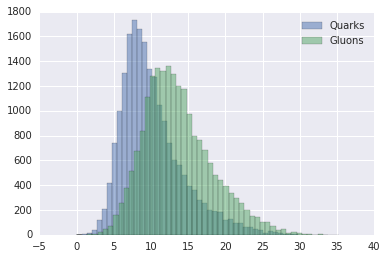

In [7]:
# some basic plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # cosmetics
%matplotlib inline
plt.hist(dfQuarks.mass, bins=50, alpha=0.5, label='Quarks');
plt.hist(dfGluons.mass, bins=50, alpha=0.5, label='Gluons');
plt.legend();

In [8]:
# Import the packages needed for the classification

# We use a simple naive bayes as a first illustration
from sklearn.naive_bayes import GaussianNB
#from sklearn.model_selection import train_test_split # model selection is available in 0.18, on swan we have scikit 0.17 for the moment
from sklearn.cross_validation import train_test_split

In [9]:
# Prepare training data frames and labels, putting together the data frames for quarks and gluons
# Training data should *not* contain the true label
# The labels should be provided in a separate array


import pandas as pd
# prepare the label array, concatenating the quarks and gluon labels
labels = pd.concat([dfQuarks['isGluon'],dfGluons['isGluon']])
# create the training data frame. We have to drop the "truth" label from those. 
trainData = pd.concat([dfQuarks.drop('isGluon',axis=1), dfGluons.drop('isGluon',axis=1)])
# Let's make sure the "isGluon" column is gone
trainData.head()

,mass,ntowers,radial,dispersion
0,8.275855,0.0,0.000000,0.000000
1,18.406378,2.0,0.000000,0.000000
2,8.124520,6.0,0.400834,0.448262
3,4.995439,3.0,0.170562,0.561912
4,7.139542,4.0,0.237577,0.445743


In [10]:
# Split the data set in a training and testing subsample, see also http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# This could be improved to use cross-validation
Xtrain, Xtest, ytrain, ytest = train_test_split(trainData, labels, random_state=1)

In [11]:
#instantiate and train the model on the train subsample
model = GaussianNB()
model.fit(Xtrain, ytrain);

In [12]:
testPrediction = model.predict(Xtest)

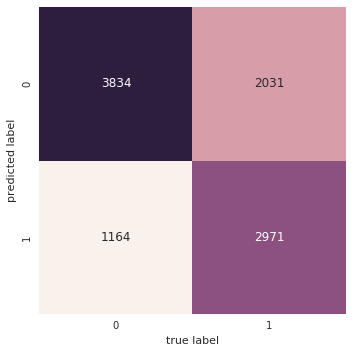

In [13]:
#Confusion matrix

%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, testPrediction)
#np.histogram2d(mat, bins=50)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
#                xticklabels=testLabels, yticklabels=testLabels)
plt.xlabel('true label')
plt.ylabel('predicted label');

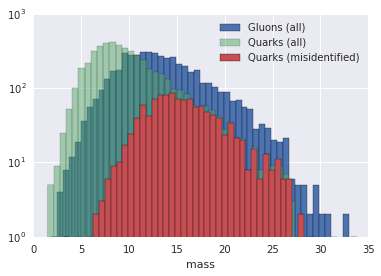

In [14]:
# Get some insight on misentification: quarks misidentified as gluons have larger mass on average, 
# they are much more gluon like
variableToPlot='mass'

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(Xtest[ytest == 1][variableToPlot], bins=50, alpha=1, label='Gluons (all)');
plt.hist(Xtest[ytest == 0][variableToPlot], bins=50, alpha=0.5, label='Quarks (all)');
plt.hist(Xtest[(testPrediction != ytest) & (ytest == 0)][variableToPlot], bins=50, alpha=1, label='Quarks (misidentified)');
plt.gca().set_yscale("log")
plt.xlabel(variableToPlot)
plt.legend();



In [15]:
# Naive Bayes can also estimate probability, which we can use to plot a ROC curve
y_score = model.predict_proba(Xtest)

In [16]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(ytest,y_score[:,1])
roc_auc = auc(fpr,tpr) 


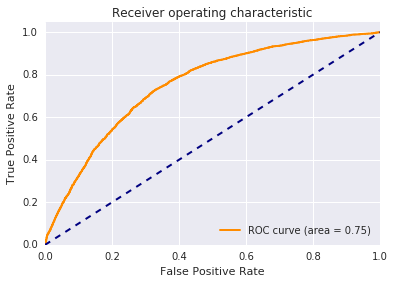

In [17]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Testing on modified dataset
in the following cells, we use the model on the modified dataset

In [18]:
# dfQuarksMod = delphes_helpers.GetJetShapes('/eos/project/i/iml/iMLChallengeQG/quarks_modified/quarks_modified_0.root', 10000)
# dfGluonsMod = delphes_helpers.GetJetShapes('/eos/project/i/iml/iMLChallengeQG/gluons_modified/gluons_modified_0.root', 10000)
# FIXME: CHANGE PATHS

dfQuarksMod = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/quarks_modified/', 20000, recompute=False)
dfGluonsMod = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/gluons_modified/', 20000, recompute=False)

Input dir: /eos/project/i/iml/IMLChallengeQG/quarks_modified/
 Processing [10000/20000]
Input dir: /eos/project/i/iml/IMLChallengeQG/gluons_modified/
 Processing [10000/20000]


Error in <TFile::TFile>: file _eos_project_i_iml_IMLChallengeQG_quarks_modified__shapes.root does not exist
Error in <TFile::TFile>: file _eos_project_i_iml_IMLChallengeQG_gluons_modified__shapes.root does not exist


In [19]:
dfQuarksMod['isGluon'] = 0
dfGluonsMod['isGluon'] = 1
dfQuarksMod.head()

,mass,ntowers,radial,dispersion,isGluon
0,14.346468,3.0,0.402398,0.510903,0
1,8.302828,12.0,0.000000,0.000000,0
2,15.908714,17.0,0.288714,0.733929,0
3,13.210590,12.0,0.000000,0.000000,0
4,12.938103,13.0,0.000000,0.000000,0


In [20]:
dfGluonsMod.head()

,mass,ntowers,radial,dispersion,isGluon
0,21.166771,29.0,1.079220,0.496385,1
1,13.149769,20.0,0.105501,0.647734,1
2,23.172453,16.0,0.294498,0.349830,1
3,9.086473,6.0,0.180580,0.424260,1
4,12.410316,6.0,1.360975,0.737150,1


In [21]:
labelsMod = pd.concat([dfQuarksMod['isGluon'],dfGluonsMod['isGluon']])
testDataMod = pd.concat([dfQuarksMod.drop('isGluon',axis=1), dfGluonsMod.drop('isGluon',axis=1)])
testDataMod.head()

,mass,ntowers,radial,dispersion
0,14.346468,3.0,0.402398,0.510903
1,8.302828,12.0,0.000000,0.000000
2,15.908714,17.0,0.288714,0.733929
3,13.210590,12.0,0.000000,0.000000
4,12.938103,13.0,0.000000,0.000000


In [22]:
y_score_mod = model.predict_proba(testDataMod)

In [23]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(labelsMod,y_score_mod[:,1])
roc_auc = auc(fpr,tpr) 



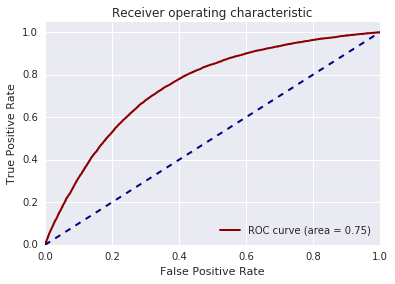

In [24]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkred',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Save AUC value
f = open("imlcoordinators_v0_auc.txt","w") 
f.write(str(roc_auc))
f.close()